## Importing packages

In [30]:
import torch
import numpy as np 
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random
import cv2
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

## Reading the images

In [31]:
#loading and preprocessing tumor images
#--resizing to 128x128 pixels to ensure consistency among all images
#--color channels of the image are split into blue (b), green (g), and red (r)
#--the channels are then merged back in the original order (since OpenCV loads images in BGR format)
tumor = []
healthy = []
for f in glob.glob('./data/brain_tumor_dataset/yes/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([b, g, r])
    tumor.append(img)

for f in glob.glob('./data/brain_tumor_dataset/no/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([b, g, r])
    healthy.append(img)

In [32]:
#list to array
healthy = np.array(healthy) 
tumor = np.array(tumor)
#concatenate datasets
All = np.concatenate((healthy, tumor))

In [33]:
healthy.shape

(85, 128, 128, 3)

In [34]:
tumor.shape

(86, 128, 128, 3)

In [35]:
np.random.choice(10, 5, replace=False)

array([6, 8, 4, 7, 0])

## Visualizing Brain MRI images

In [36]:
#visualizing random samples of MRI images from two categories: healthy and tumor
#for each image in the random sample of healthy images, a subplot is created in a single row (plt.subplot(1, num, i+1)). 
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

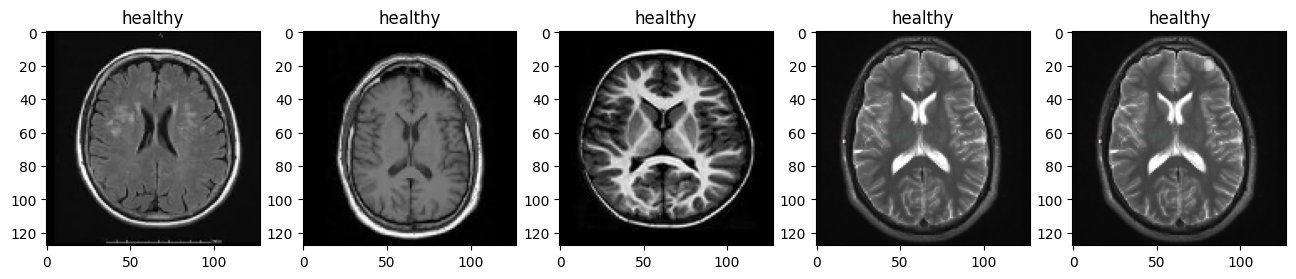

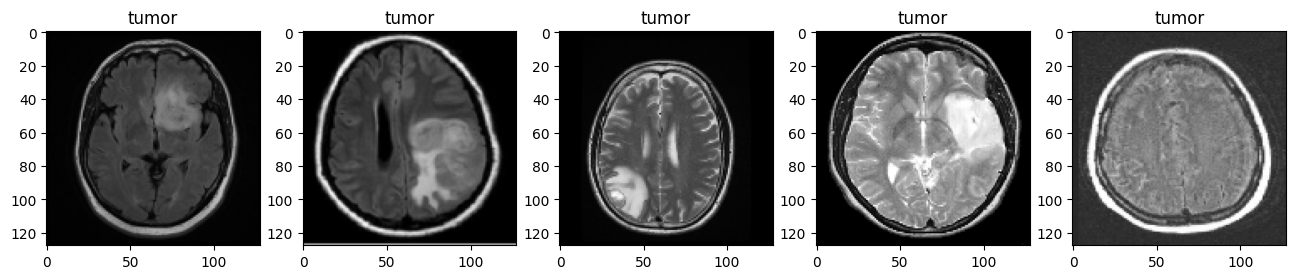

In [37]:
plot_random(healthy, tumor)

## Create torch dataset class

In [38]:
class Dataset(object):
    """An abstract class representing a Dataset.

    __getitem__(self, index) Method:
        This is a special method in Python that allows instances of the class to use the indexing syntax (e.g., dataset[0] to get the first element). In the context of a dataset, this method is supposed to return the index-th sample from the dataset.
        The base class raises a NotImplementedError, indicating that any subclass deriving from Dataset must provide its own implementation of how to access data by index. This is essential because the way data is stored and retrieved can vary widely between different datasets.

    __len__(self) Method:
        Another special method that allows Python to use the len() function on instances of the class (e.g., len(dataset) to get the number of items in the dataset).
        Similar to __getitem__, it raises a NotImplementedError, requiring subclasses to implement their own method for reporting the size of the dataset. This is crucial for knowing the dataset's bounds and iterating over it.

    __add__(self, other) Method:
        This method enables the use of the + operator with instances of the class, allowing two datasets to be concatenated simply by using dataset1 + dataset2.
        The method returns an instance of a ConcatDataset, presumably another class defined elsewhere, initialized with a list containing self and other. This implies that ConcatDataset is designed to handle multiple datasets as one unified dataset.
        By implementing this method, the class provides a convenient way to merge datasets, which can be very useful in situations where data from multiple sources needs to be combined into a single dataset for training or evaluation in machine learning tasks.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [39]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    # Returns the total number of images in the dataset by accessing the shape of the self.images array
    def __len__(self):
        return self.images.shape[0]
    
    # Returns a dictionary with two keys: 'image' for the image at the specified index and 'label' for its corresponding label
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    # Divides each pixel value by 255 to scale the image pixel values to the range [0, 1]
    def normalize(self):
        self.images = self.images/255.0

In [40]:
mri_dataset = MRI()
mri_dataset.normalize()